In [1]:
from numpy import *
import numpy
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas
import datetime
import seaborn

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
import sklearn
from sklearn import metrics

import sys
sys.path.append("/Users/efandel/Desktop/iPython Tools")
from rtbpythonutils import *
%matplotlib inline

In [40]:
feature_columns = ['bids.app_bundle','bids.app_aid','bids.fiksu_app_id','bids.ad_type','bids.connection_speed']

negative_ratio = 1.0

positives = redshift_compute('''
select 1 as label,
  %s
from bids_partitions.p20170719 bids
inner join impressions_partitions.p20170719 as imps on imps.adnetwork_request_id = bids.adnetwork_request_id
inner join click_ios_partitions.p20170719 as clicks on clicks.adnetwork_request_id = imps.adnetwork_request_id
inner join conversions_partitions.p20170719 as convs on convs.adnetwork_request_id = clicks.adnetwork_request_id

where bids.fiksu_app_id != 0
order by random()
limit 100000

'''%(', '.join(feature_columns)))

negatives = redshift_compute('''
select 0 as label,
  %s
from bids_partitions.p20170719 bids
inner join impressions_partitions.p20170719 as imps on imps.adnetwork_request_id = bids.adnetwork_request_id
inner join click_ios_partitions.p20170719 as clicks on clicks.adnetwork_request_id = imps.adnetwork_request_id
left outer join conversions_partitions.p20170719 as convs on convs.adnetwork_request_id = clicks.adnetwork_request_id

where bids.fiksu_app_id != 0
and convs.adnetwork_request_id is null
order by random()
limit %s
'''%(', '.join(feature_columns), int(len(positives)*negative_ratio)))
all_data = pandas.concat([positives, negatives])

def random_split(X,Y, frac=0.8):
    msk = numpy.random.rand(len(X)) < frac
    return X[msk], Y[msk], X[~msk], Y[~msk]

In [41]:
all_data.label.unique()

array([1, 0])

In [35]:
len(all_data)

2342

In [48]:
columns = ['app_bundle']
X = pandas.get_dummies(all_data[columns])
Y = all_data['label']

X_train, Y_train, X_test, Y_test = random_split(X, Y)

In [49]:
len(Y_test)

423

Logistic Regression
('Training Accuracy', 70.43)
('Test Accuracy', 65.96)
('Training Loss', 0.57627621798946949)
('Test Loss', 0.61414066840372106)
('Mean Loss', 0.69414316256030739)


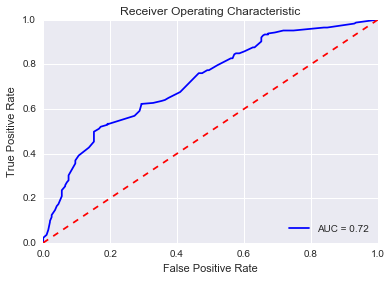

In [50]:
method = "Logistic Regression"


model = LogisticRegression()
model.fit(X_train, Y_train)

train_acc = round(model.score(X_train, Y_train) * 100, 2)
test_acc = round(model.score(X_test, Y_test) * 100, 2)

train_loss = sklearn.metrics.log_loss(Y_train, model.predict_proba(X_train)[:,1])
test_loss = sklearn.metrics.log_loss(Y_test, model.predict_proba(X_test)[:,1])

mean_loss = sklearn.metrics.log_loss(Y_test, ones(len(Y_test)) * mean(Y_train))


print(method)
print("Training Accuracy", train_acc)
print("Test Accuracy", test_acc)
print("Training Loss", train_loss)
print("Test Loss", test_loss)
print("Mean Loss", mean_loss)

probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### What happens when we use app_aid instead of app_bundle?

In [46]:
columns = ['app_aid']
X = pandas.get_dummies(all_data[columns])
Y = all_data['label']

X_train, Y_train, X_test, Y_test = random_split(X, Y)

Logistic Regression
('Training Accuracy', 71.5)
('Test Accuracy', 67.62)
('Training Loss', 0.56529804611316314)
('Test Loss', 0.61893634886841897)
('Mean Loss', 0.69319215312208382)


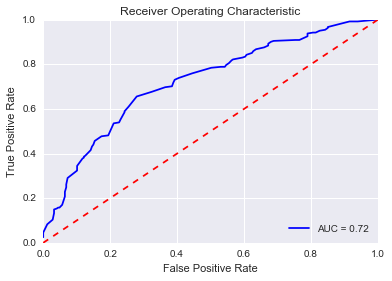

In [47]:
method = "Logistic Regression"


model = LogisticRegression()
model.fit(X_train, Y_train)

train_acc = round(model.score(X_train, Y_train) * 100, 2)
test_acc = round(model.score(X_test, Y_test) * 100, 2)

train_loss = sklearn.metrics.log_loss(Y_train, model.predict_proba(X_train)[:,1])
test_loss = sklearn.metrics.log_loss(Y_test, model.predict_proba(X_test)[:,1])

mean_loss = sklearn.metrics.log_loss(Y_test, ones(len(Y_test)) * mean(Y_train))


print(method)
print("Training Accuracy", train_acc)
print("Test Accuracy", test_acc)
print("Training Loss", train_loss)
print("Test Loss", test_loss)
print("Mean Loss", mean_loss)

probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()